In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [3]:
spy_df = pd.read_csv('data/SPY_25_years_data.csv', parse_dates=['Date'])
spy_df.sort_values('Date', inplace=True)
spy_df.reset_index(drop=True, inplace=True)

features = ['Open', 'High', 'Low', 'Close']

data = spy_df[features].values

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [4]:
def create_sequences(data, window_size=30, target_step=1):
    """
    data: NumPy array of shape (num_samples, num_features)
    window_size: how many past days we look at
    target_step: how many days ahead we want to predict
                 (1 for next day, 5 for 5 days ahead, etc.)
    Returns:
        X: shape (number_of_sequences, window_size, num_features)
        y: shape (number_of_sequences, num_features) or (number_of_sequences,)
    """
    X, y = [], []
    num_samples = len(data)
    
    for i in range(num_samples - window_size - target_step + 1):
        X_seq = data[i:i+window_size]          # Past 'window_size' days
        y_seq = data[i+window_size+target_step-1]  # The day we want to predict
        X.append(X_seq)
        # only predict close
        y.append(y_seq[3])  

    X = np.array(X)
    y = np.array(y)
    return X, y

window_size = 30  
target_step = 1   
X_all, y_all = create_sequences(data_scaled, window_size=window_size, target_step=target_step)

print("X_all shape:", X_all.shape)  
print("y_all shape:", y_all.shape)  


X_all shape: (6257, 30, 4)
y_all shape: (6257,)


In [5]:
def rolling_split(X, y, n_splits=5):
    """
    Generates train/test indices for rolling/walk-forward validation.
    n_splits: how many windows you want
    """
    n_samples = len(X)
    indices = np.arange(n_samples)
    
    split_size = n_samples // (n_splits+1)  
    
    splits = []
    for i in range(1, n_splits+1):
        # Train from 0 to i*split_size
        train_end = i * split_size
        # Test from train_end+1 to train_end+split_size
        test_end = (i+1) * split_size
        
        X_train_indices = indices[:train_end]
        X_test_indices = indices[train_end:test_end]
        
        splits.append((X_train_indices, X_test_indices))
    return splits

splits = rolling_split(X_all, y_all, n_splits=5)
for idx, (tr, te) in enumerate(splits):
    print(f"Split {idx}: Train size = {len(tr)}, Test size = {len(te)}")


Split 0: Train size = 1042, Test size = 1042
Split 1: Train size = 2084, Test size = 1042
Split 2: Train size = 3126, Test size = 1042
Split 3: Train size = 4168, Test size = 1042
Split 4: Train size = 5210, Test size = 1042


In [7]:
train_size = int(0.8 * len(X_all))
X_train, X_test = X_all[:train_size], X_all[train_size:]
y_train, y_test = y_all[:train_size], y_all[train_size:]


In [8]:
class SPYDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset = SPYDataset(X_train, y_train)
test_dataset = SPYDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
class LSTMTimeSeries(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, output_size=1):
        super(LSTMTimeSeries, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))  # out: (batch, seq_len, hidden_size)
        
        out = out[:, -1, :]  
        out = self.fc(out)  
        return out


### Hyperparameters

In [10]:
input_size = len(features)  
hidden_size = 64
num_layers = 1
output_size = 1  
num_epochs = 10
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMTimeSeries(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)  
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * X_batch.size(0)
    
    epoch_loss /= len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")


Epoch [1/10], Loss: 0.000677
Epoch [2/10], Loss: 0.000898
Epoch [3/10], Loss: 0.001458
Epoch [4/10], Loss: 0.001536
Epoch [5/10], Loss: 0.001254
Epoch [6/10], Loss: 0.000846
Epoch [7/10], Loss: 0.000539
Epoch [8/10], Loss: 0.000308
Epoch [9/10], Loss: 0.000156
Epoch [10/10], Loss: 0.000078


Test RMSE: 6.265268558879323


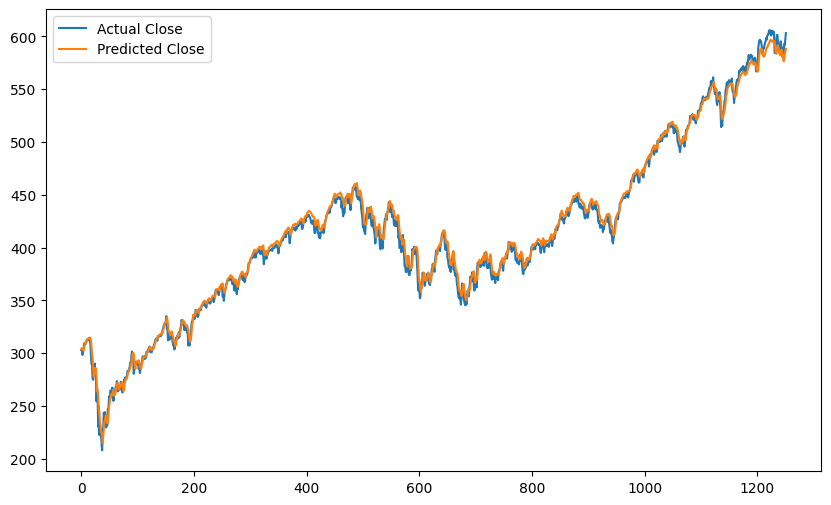

In [11]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.numpy().reshape(-1, 1))

predictions = np.vstack(predictions)
actuals = np.vstack(actuals)

# Need to invert the scaling if we want actual price predictions
pred_close_scaled = np.zeros((len(predictions), data.shape[1]))  
act_close_scaled = np.zeros((len(actuals), data.shape[1]))

pred_close_scaled[:, 3] = predictions.flatten()
act_close_scaled[:, 3] = actuals.flatten()

# inverse transform
pred_close = scaler.inverse_transform(pred_close_scaled)[:, 3]
act_close  = scaler.inverse_transform(act_close_scaled)[:, 3]

mse = np.mean((pred_close - act_close)**2)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

plt.figure(figsize=(10,6))
plt.plot(act_close, label='Actual Close')
plt.plot(pred_close, label='Predicted Close')
plt.legend()
plt.show()
